In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [37]:
import pandas as pd

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

from tensorflow import keras
import tensorflow as tf
import os

import matplotlib.pyplot as plt

from gensim.models.keyedvectors import Word2VecKeyedVectors

from gensim.models import KeyedVectors

from tensorflow.keras.initializers import Constant
import pprint

import gensim
import gensim.models

## 1) 데이터 준비와 확인

In [38]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [39]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  #인덱스 정의
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]  #unknown으로 반환
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [40]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [41]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [42]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))


문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


(array([8.5250e+03, 4.0698e+04, 4.2547e+04, 3.2489e+04, 2.3485e+04,
        1.3847e+04, 7.4350e+03, 3.8870e+03, 4.0800e+03, 3.3580e+03,
        2.7770e+03, 2.2930e+03, 2.1500e+03, 2.3170e+03, 1.7190e+03,
        1.8410e+03, 1.1110e+03, 4.8800e+02, 1.8600e+02, 7.1000e+01,
        2.1000e+01, 5.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  0.        ,   3.86666667,   7.73333333,  11.6       ,
         15.46666667,  19.33333333,  23.2       ,  27.06666667,
         30.93333333,  34.8       ,  38.66666667,  42.53333333,
         46.4       ,  50.26666667,  54.13333333,  58.        ,
         61.86666667,  65.73333333,  69.6       ,  73.46666667,
         77.33333333,  81.2       ,  85.06666667,  88.93333333,
         92.8       ,  96.66666667, 100.53333333, 104.4       ,
        108.26666667, 112.13333333, 116.        ]),
 <BarContainer object of 30 artists>)

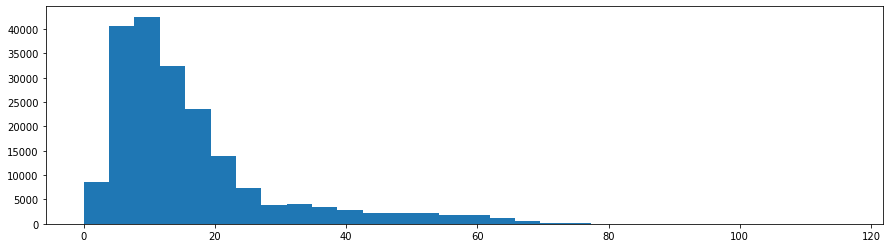

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
# num_tokens
plt.figure(figsize=(15,4))
plt.hist(num_tokens, bins=30)

# 문장 내 단어의 경우 7~15개 사이로 포진되어있는 것을 확인

In [43]:
# 전체의 90% 수준인 67정도로 max_len 설정
# 전체의 90% 수준안 32정도로 진행했을 경우 acc는 85% 정도로 보임 (1차 진행 결과) 
max_tokens = np.mean(num_tokens) + 4 * np.std(num_tokens)
maxlen = int(max_tokens) # 최대 길이
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  67
전체 문장의 0.99755809131817%가 maxlen 설정값 이내에 포함됩니다. 


In [44]:
#keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가 (pre)
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)


## 4) 모델 구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

- lstm을 통한 리뷰감성분석
- Cnn을 통한 리뷰 감성분석
- BIlstm을 통한 리뷰 감성분석

### LSTM

In [34]:
# LSTM acc 82.4
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### Bi_LSTM

In [35]:
#BI_LSTM acc 82.5

import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model_2 = keras.Sequential()
model_2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(keras.layers.Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model_2.add(keras.layers.Dense(8, activation='relu'))
model_2.add(keras.layers.Dense(1, activation='sigmoid'))


model_2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               148480    
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 310,545
Trainable params: 310,545
Non-trainable params: 0
_________________________________________________________________


### 1-D CNN

In [13]:
#1-D CNN
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model_3 = keras.Sequential()
model_3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_3.add(keras.layers.MaxPooling1D(5))
model_3.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_3.add(keras.layers.GlobalMaxPooling1D())
model_3.add(keras.layers.Dense(8, activation='relu'))
model_3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [30]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 67)
(136182,)


## 5) 모델 훈련 개시

In [45]:
def model_train(a,epoch,batch):
    a.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
    epochs=epoch

    history = model.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=batch,
                        validation_data=(X_val, y_val),
                        verbose=1)
    print("-----------")
    results = model.evaluate(X_test,  y_test, verbose=2)

    print('test_loss : '+ str(results[0]))
    print('test_auc : '+ str(results[1]))
    
    print("-----------")
    
    history_dict = history.history
    
    #loss graph 시각화
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
    #auc graph 시각화
    plt.clf()   # 그림을 초기화합니다

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
    return

Epoch 1/5
2128/2128 [==============================] - 15s 6ms/step - loss: 0.4444 - accuracy: 0.8131 - val_loss: 0.3517 - val_accuracy: 0.8499
Epoch 2/5
2128/2128 [==============================] - 11s 5ms/step - loss: 0.3293 - accuracy: 0.8608 - val_loss: 0.3319 - val_accuracy: 0.8565
Epoch 3/5
2128/2128 [==============================] - 11s 5ms/step - loss: 0.2990 - accuracy: 0.8736 - val_loss: 0.3255 - val_accuracy: 0.8603
Epoch 4/5
2128/2128 [==============================] - 11s 5ms/step - loss: 0.2708 - accuracy: 0.8866 - val_loss: 0.3267 - val_accuracy: 0.8607
Epoch 5/5
2128/2128 [==============================] - 11s 5ms/step - loss: 0.2465 - accuracy: 0.8978 - val_loss: 0.3261 - val_accuracy: 0.8626
-----------
1537/1537 - 3s - loss: 0.3372 - accuracy: 0.8573
test_loss : 0.3371568024158478
test_auc : 0.8573346734046936
-----------


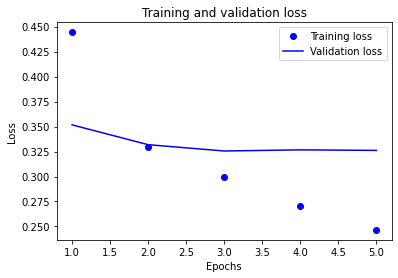

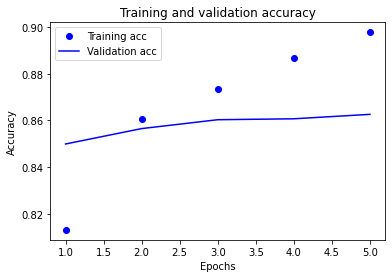

In [32]:
#lstm
model_train(model,5,64)

Epoch 1/10
266/266 [==============================] - 2s 6ms/step - loss: 0.1334 - accuracy: 0.9503 - val_loss: 0.6239 - val_accuracy: 0.8389
Epoch 2/10
266/266 [==============================] - 2s 6ms/step - loss: 0.1301 - accuracy: 0.9520 - val_loss: 0.6590 - val_accuracy: 0.8372
Epoch 3/10
266/266 [==============================] - 2s 6ms/step - loss: 0.1262 - accuracy: 0.9535 - val_loss: 0.6884 - val_accuracy: 0.8404
Epoch 4/10
266/266 [==============================] - 2s 6ms/step - loss: 0.1226 - accuracy: 0.9555 - val_loss: 0.7338 - val_accuracy: 0.8406
Epoch 5/10
266/266 [==============================] - 2s 6ms/step - loss: 0.1206 - accuracy: 0.9559 - val_loss: 0.7449 - val_accuracy: 0.8393
Epoch 6/10
266/266 [==============================] - 2s 6ms/step - loss: 0.1158 - accuracy: 0.9576 - val_loss: 0.7657 - val_accuracy: 0.8370
Epoch 7/10
266/266 [==============================] - 2s 6ms/step - loss: 0.1150 - accuracy: 0.9581 - val_loss: 0.7774 - val_accuracy: 0.8374
Epoch 

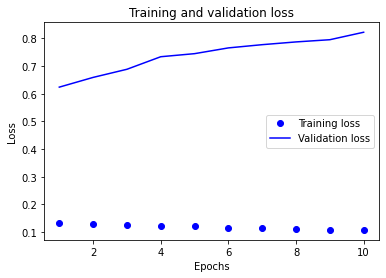

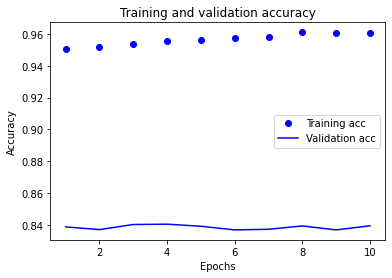

In [113]:
# BI_LSTM
model_train(model_2,10,512)

Epoch 1/10
266/266 [==============================] - 2s 6ms/step - loss: 0.2121 - accuracy: 0.9149 - val_loss: 0.3604 - val_accuracy: 0.8580
Epoch 2/10
266/266 [==============================] - 2s 6ms/step - loss: 0.2046 - accuracy: 0.9184 - val_loss: 0.3703 - val_accuracy: 0.8570
Epoch 3/10
266/266 [==============================] - 2s 6ms/step - loss: 0.1992 - accuracy: 0.9206 - val_loss: 0.3811 - val_accuracy: 0.8554
Epoch 4/10
266/266 [==============================] - 2s 6ms/step - loss: 0.1949 - accuracy: 0.9224 - val_loss: 0.3904 - val_accuracy: 0.8555
Epoch 5/10
266/266 [==============================] - 2s 6ms/step - loss: 0.1904 - accuracy: 0.9247 - val_loss: 0.4006 - val_accuracy: 0.8539
Epoch 6/10
266/266 [==============================] - 2s 6ms/step - loss: 0.1854 - accuracy: 0.9270 - val_loss: 0.4068 - val_accuracy: 0.8506
Epoch 7/10
266/266 [==============================] - 2s 6ms/step - loss: 0.1807 - accuracy: 0.9295 - val_loss: 0.4146 - val_accuracy: 0.8524
Epoch 

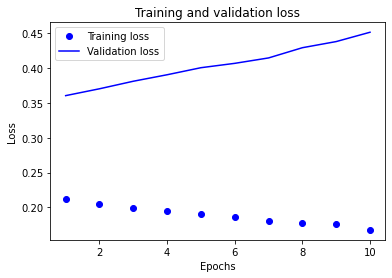

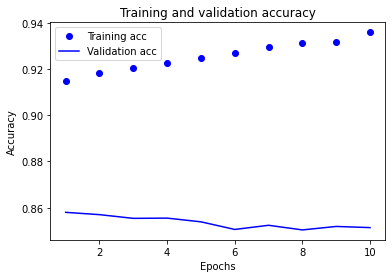

In [36]:
#1-D Convolution Neural Network(1-D CNN)모델
model_train(model_3,10,512)

### 7) 학습된 Embedding 레이어 분석

In [15]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

def embedding_analyze(select_model, keyword):
    embedding_layer = select_model.layers[0]
    weights = embedding_layer.get_weights()[0]
    
    # 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
    word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_cnn.txt'
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
    vectors = select_model.get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()
    
    word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
    vector = word_vectors[keyword]
    
    print(keyword)
    print(vector)
    print('유사어')
    print(word_vectors.similar_by_word(keyword))
    

In [18]:
print("LSTM 결과")
embedding_analyze(model,'재미')

LSTM 결과
재미
[ 0.0313375   0.03422682 -0.04766626  0.03382237 -0.01130565  0.0156507
  0.03412005 -0.02787739 -0.0486041   0.02692199 -0.04319248  0.02048153
 -0.02035685  0.02163221 -0.00176562 -0.0087932 ]
유사어
[('써도', 0.8529578447341919), ('난생', 0.8141534924507141), ('연예계', 0.7994961142539978), ('기', 0.7850935459136963), ('마요', 0.7736622095108032), ('언젠간', 0.7472966909408569), ('이보영', 0.7403311133384705), ('푼', 0.7172853946685791), ('이브', 0.7152299880981445), ('지어다', 0.7066940665245056)]


In [17]:
print("BI_LSTM 결과")
embedding_analyze(model_2,"재미")

BI_LSTM 결과
재미
[ 0.0185875  -0.04097668 -0.00777539 -0.00204594 -0.03041318  0.0358394
 -0.02659007  0.03447062  0.02536282 -0.02722623  0.03499616 -0.02222968
 -0.04609264 -0.048563   -0.03313947  0.01549294]
유사어
[('움직임', 0.779560387134552), ('진실', 0.747739851474762), ('욜', 0.746534526348114), ('나름', 0.7386741042137146), ('일으킨', 0.730904221534729), ('발상', 0.7294308543205261), ('다잉', 0.7274775505065918), ('식스', 0.7200219035148621), ('J', 0.715254545211792), ('정려원', 0.7151606678962708)]


In [126]:
print("CNN 결과")
embedding_analyze(model_3,"재미")

CNN 결과
재미
[ 0.03977204 -0.03177086  0.02701112 -0.03080372  0.00156092 -0.02524379
  0.02755201 -0.02778621 -0.01376625 -0.00317897  0.02007485 -0.02376372
 -0.02839993 -0.03904442  0.01615189 -0.01757161]
유사어
[('30', 0.7990280389785767), ('럼', 0.754493772983551), ('반열', 0.7463577389717102), ('스러움', 0.7332896590232849), ('레인', 0.7263188362121582), ('낚시', 0.7225335240364075), ('모순', 0.720977246761322), ('이연희', 0.7139936685562134), ('윤제문', 0.7059674859046936), ('인종', 0.7011597156524658)]


### 8) 한국어 W2V 임베딩을 활용하여 성능 개선
- 한국어 W2V 임베딩을 활용하여 이전 학습보다 근소한 성능 개선을 보였음
- 동일한 파라미터로 진행했을 경우 1~3%정도의 성능향상이 있는 것을 확인함
- 동일한 코드를 다중 실행하여 이전 기록을 확인하긴 어렵지만 Bi_LSTM, LSTM의 성능차이는 아래와 같음
    - LSTM auc 0.824 -> 0.835
    - Bi-LSTM acu 0.825 -> 0.848
- Bi-LSTM의 일부 셋팅값을 수정한 결과 0.8508까지 향상됨
    - 기존 : (total params : 310,545, batch_size : 512, epochs : 50)
    - 변경 : (total params : 1,234,753, batch_size : 512, epochs : 20)

In [46]:
# 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model' 
word2vec = gensim.models.Word2Vec.load(word2vec_path)
word_vectors = Word2VecKeyedVectors.load(word2vec_path)

vector = word_vectors.wv["재미"]
word2vec.wv.similar_by_word("재미")
# print(vector)

[('묘미', 0.6163142919540405),
 ('취미', 0.6034970283508301),
 ('흥미', 0.5939850211143494),
 ('유머', 0.5888698101043701),
 ('보람', 0.5689517259597778),
 ('즐거움', 0.5631207823753357),
 ('개그', 0.5552946329116821),
 ('이야기', 0.5536993741989136),
 ('연애', 0.552293598651886),
 ('열의', 0.546456515789032)]

In [47]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [48]:
# def model_train(a):
    
#Bi-LSTM 모델 구성
model_4 = keras.Sequential()
model_4.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  #카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   #trainable을 True로 주면 Fine-tuning
model_4.add(keras.layers.LSTM(128))
model_4.add(keras.layers.Dense(1, activation='sigmoid'))

model_4.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 67, 100)           1000000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


In [49]:
#BI_LSTM 모델 구성
model_5 = keras.Sequential()
model_5.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  #카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   #trainable을 True로 주면 Fine-tuning
model_5.add(keras.layers.Bidirectional(LSTM(128)))
model_5.add(keras.layers.Dense(1, activation='sigmoid'))

model_5.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 67, 100)           1000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               234496    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 1,234,753
Trainable params: 1,234,753
Non-trainable params: 0
_________________________________________________________________


In [50]:
#1-D CNN
# model 설계
model_6 = keras.Sequential()
model_6.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  #카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   #trainable을 True로 주면 Fine-tuning
# model_6.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_6.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_6.add(keras.layers.MaxPooling1D(5))
model_6.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_6.add(keras.layers.GlobalMaxPooling1D())
model_6.add(keras.layers.Dense(8, activation='relu'))
model_6.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_6.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 67, 100)           1000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 61, 16)            11216     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12, 16)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 6, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_17 (Dense)             (None, 1)               

Epoch 1/20
2128/2128 [==============================] - 11s 5ms/step - loss: 0.2242 - accuracy: 0.9083 - val_loss: 0.3332 - val_accuracy: 0.8618
Epoch 2/20
2128/2128 [==============================] - 11s 5ms/step - loss: 0.2066 - accuracy: 0.9170 - val_loss: 0.3485 - val_accuracy: 0.8612
Epoch 3/20
2128/2128 [==============================] - 11s 5ms/step - loss: 0.1915 - accuracy: 0.9239 - val_loss: 0.3804 - val_accuracy: 0.8606
Epoch 4/20
2128/2128 [==============================] - 11s 5ms/step - loss: 0.1776 - accuracy: 0.9304 - val_loss: 0.4069 - val_accuracy: 0.8588
Epoch 5/20
2128/2128 [==============================] - 11s 5ms/step - loss: 0.1664 - accuracy: 0.9353 - val_loss: 0.4019 - val_accuracy: 0.8574
Epoch 6/20
2128/2128 [==============================] - 11s 5ms/step - loss: 0.1537 - accuracy: 0.9411 - val_loss: 0.4484 - val_accuracy: 0.8542
Epoch 7/20
2128/2128 [==============================] - 11s 5ms/step - loss: 0.1454 - accuracy: 0.9445 - val_loss: 0.4611 - val_ac

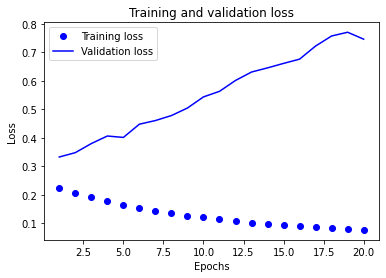

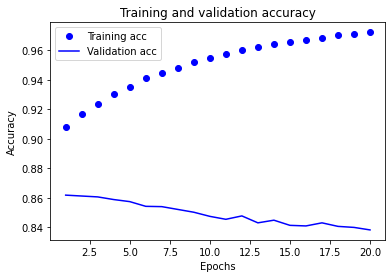

In [33]:
model_train(model_4,20,64)

Epoch 1/30
532/532 [==============================] - 3s 6ms/step - loss: 0.0404 - accuracy: 0.9859 - val_loss: 1.2790 - val_accuracy: 0.8212
Epoch 2/30
532/532 [==============================] - 3s 6ms/step - loss: 0.0352 - accuracy: 0.9879 - val_loss: 1.2917 - val_accuracy: 0.8204
Epoch 3/30
532/532 [==============================] - 3s 5ms/step - loss: 0.0342 - accuracy: 0.9880 - val_loss: 1.3772 - val_accuracy: 0.8220
Epoch 4/30
532/532 [==============================] - 3s 6ms/step - loss: 0.0330 - accuracy: 0.9886 - val_loss: 1.4333 - val_accuracy: 0.8215
Epoch 5/30
532/532 [==============================] - 3s 6ms/step - loss: 0.0360 - accuracy: 0.9876 - val_loss: 1.4293 - val_accuracy: 0.8239
Epoch 6/30
532/532 [==============================] - 3s 5ms/step - loss: 0.0336 - accuracy: 0.9884 - val_loss: 1.4726 - val_accuracy: 0.8236
Epoch 7/30
532/532 [==============================] - 3s 6ms/step - loss: 0.0315 - accuracy: 0.9890 - val_loss: 1.5323 - val_accuracy: 0.8226
Epoch 

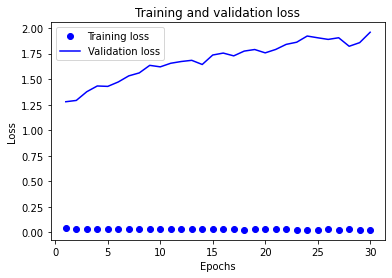

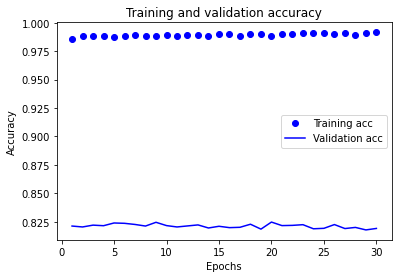

In [50]:
model_train(model_5,20,512)

Epoch 1/20
266/266 [==============================] - 2s 6ms/step - loss: 0.0219 - accuracy: 0.9923 - val_loss: 1.9500 - val_accuracy: 0.8201
Epoch 2/20
266/266 [==============================] - 2s 6ms/step - loss: 0.0208 - accuracy: 0.9928 - val_loss: 1.9822 - val_accuracy: 0.8188
Epoch 3/20
266/266 [==============================] - 2s 6ms/step - loss: 0.0201 - accuracy: 0.9930 - val_loss: 2.0306 - val_accuracy: 0.8196
Epoch 4/20
266/266 [==============================] - 2s 6ms/step - loss: 0.0198 - accuracy: 0.9931 - val_loss: 2.0737 - val_accuracy: 0.8192
Epoch 5/20
266/266 [==============================] - 2s 6ms/step - loss: 0.0203 - accuracy: 0.9930 - val_loss: 2.0496 - val_accuracy: 0.8198
Epoch 6/20
266/266 [==============================] - 2s 6ms/step - loss: 0.0200 - accuracy: 0.9930 - val_loss: 2.0816 - val_accuracy: 0.8188
Epoch 7/20
266/266 [==============================] - 2s 6ms/step - loss: 0.0194 - accuracy: 0.9931 - val_loss: 2.1608 - val_accuracy: 0.8193
Epoch 

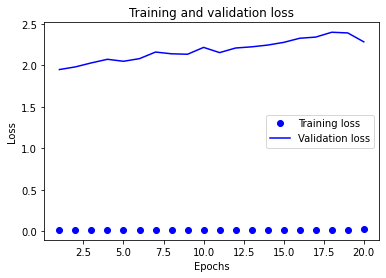

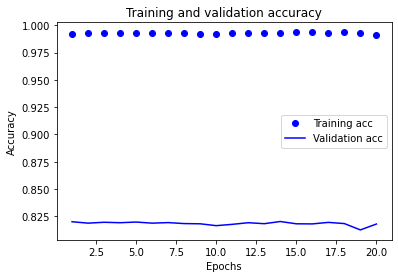

In [51]:
model_train(model_6,20,512)

### 성공
- 학습 진행간에 'model_train'로 중복 사용시 모델이 가중되어 학습되는 문제가 발생하여 이로인한 과적합이 되는 현상이 발생되었음
- 기존에 생성해놨던 'model_train'사용이 아닌 일반적인 compile로 실행하였더니 accuracy가 0.8508을 얻을 수 있었음
- 진행했던 모델은 초기 학습 진행시 가장 성능이 높게 나왔던 Bi-LSTM으로 진행하였음

In [52]:
model_5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model_5.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 10s 30ms/step - loss: 0.4671 - accuracy: 0.7723 - val_loss: 0.3751 - val_accuracy: 0.8339
Epoch 2/20
266/266 [==============================] - 7s 27ms/step - loss: 0.3437 - accuracy: 0.8492 - val_loss: 0.3376 - val_accuracy: 0.8495
Epoch 3/20
266/266 [==============================] - 7s 28ms/step - loss: 0.2974 - accuracy: 0.8721 - val_loss: 0.3211 - val_accuracy: 0.8613
Epoch 4/20
266/266 [==============================] - 7s 28ms/step - loss: 0.2686 - accuracy: 0.8865 - val_loss: 0.3140 - val_accuracy: 0.8637
Epoch 5/20
266/266 [==============================] - 7s 28ms/step - loss: 0.2447 - accuracy: 0.8988 - val_loss: 0.3172 - val_accuracy: 0.8663
Epoch 6/20
266/266 [==============================] - 7s 28ms/step - loss: 0.2223 - accuracy: 0.9092 - val_loss: 0.3222 - val_accuracy: 0.8666
Epoch 7/20
266/266 [==============================] - 7s 28ms/step - loss: 0.2033 - accuracy: 0.9183 - val_loss: 0.3251 - val_accuracy: 0.867

In [56]:
# 테스트셋을 통한 모델 평가
results = model_5.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.6938 - accuracy: 0.8508
[0.693789005279541, 0.8507842421531677]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


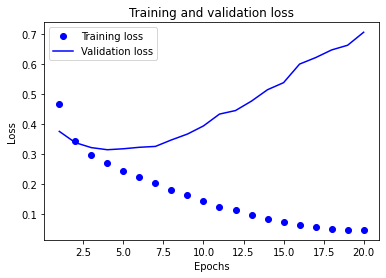

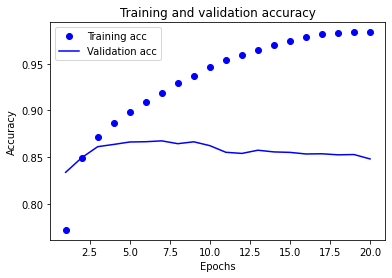

In [57]:
# loss auc 시각화
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 회고
- 학습된 Embedding 레이어를 활용한다면 성능개선과 모델구현의 시간감소를 얻을 수 있다는 것을 확인함
- 마지막에 기록을 삭제하였지만 bert를 활용한 학습을 시도하였고, 소요되는 학습시간으로 인하여 실험을 도중에 중단하였습니다.
    - [bert를 활용한 감성분류](https://colab.research.google.com/drive/1tIf0Ugdqg4qT7gcxia3tL7und64Rv1dP#scrollTo=H5mANMwKkA0D)
- 학습 과정간에 early stop을 진행하는 것이 아닌 epochs를 늘려 학습을 진행하여 손실함수의 추이를 지켜보고자 하였고 고저의 차이는 있지만 실험을 진행한 부분까지 val의 loss값과 auc의 값은 train값과의 차이가 커지는 것을 확인하였습니다. 추후 유사 프로젝트 진행시 한번 다시 실험해보고자 합니다.

## appendix
- 초기 lstm과 bi-lstm의 실험기록입니다.

In [86]:
# lstm 기록

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.9205 - accuracy: 0.8244
[0.9205284714698792, 0.824440062046051]


In [87]:
# loss auc 시각화
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


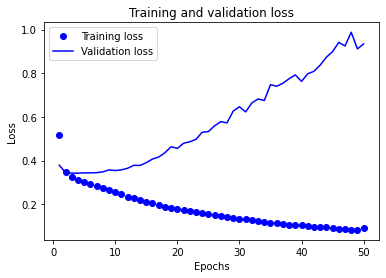

In [88]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

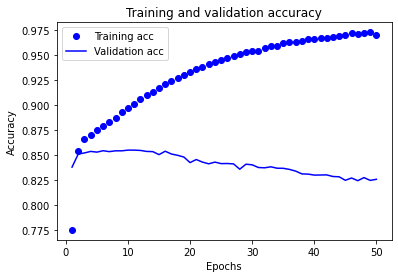

In [89]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [90]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_rnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [91]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [92]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.09365013, -0.18111587,  0.11508346,  0.02602549, -0.01304742,
       -0.15247028,  0.05695869, -0.08304574,  0.21775301,  0.06961625,
       -0.19662194,  0.16037063,  0.0491562 , -0.13886473,  0.12941886,
        0.00200075], dtype=float32)

In [93]:
word_vectors.similar_by_word("재미")

[('긴장감', 0.8188729882240295),
 ('의리', 0.7891600728034973),
 ('몰입', 0.7726874351501465),
 ('흥미', 0.75739586353302),
 ('진', 0.7436588406562805),
 ('이렇게', 0.7202274799346924),
 ('읽', 0.7063639760017395),
 ('25', 0.7062981724739075),
 ('대립', 0.7055391669273376),
 ('강호동', 0.6997005343437195)]

In [75]:
X_train

array([[   0,    0,    0, ...,   20,   33,  748],
       [   0,    0,    0, ...,   15,   44,  391],
       [   0,    0,    0, ...,   24,  205,    2],
       ...,
       [   0,    0,    0, ..., 2710,    6,   18],
       [   0,    0,    0, ...,   60,  395, 8572],
       [   0,    0,    0, ...,   88, 2740,    5]], dtype=int32)

### 2) BI_LSTM 진행

In [97]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.summary()

In [98]:
embedding_dim = 100
hidden_units = 128

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.summary()
# # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               148480    
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 310,545
Trainable params: 310,545
Non-trainable params: 0
_________________________________________________________________


In [99]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/50
266/266 [==============================] - 10s 25ms/step - loss: 0.4845 - accuracy: 0.7555 - val_loss: 0.3485 - val_accuracy: 0.8517
Epoch 2/50
266/266 [==============================] - 6s 22ms/step - loss: 0.3381 - accuracy: 0.8566 - val_loss: 0.3416 - val_accuracy: 0.8509
Epoch 3/50
266/266 [==============================] - 6s 22ms/step - loss: 0.3209 - accuracy: 0.8649 - val_loss: 0.3413 - val_accuracy: 0.8512
Epoch 4/50
266/266 [==============================] - 6s 22ms/step - loss: 0.3095 - accuracy: 0.8700 - val_loss: 0.3391 - val_accuracy: 0.8551
Epoch 5/50
266/266 [==============================] - 6s 22ms/step - loss: 0.2973 - accuracy: 0.8766 - val_loss: 0.3350 - val_accuracy: 0.8540
Epoch 6/50
266/266 [==============================] - 6s 22ms/step - loss: 0.2819 - accuracy: 0.8839 - val_loss: 0.3328 - val_accuracy: 0.8577
Epoch 7/50
266/266 [==============================] - 6s 23ms/step - loss: 0.2631 - accuracy: 0.8931 - val_loss: 0.3304 - val_accuracy: 0.858

In [100]:
#학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 1.1223 - accuracy: 0.8252
[1.1223194599151611, 0.8252334594726562]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


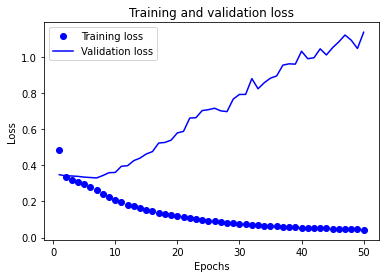

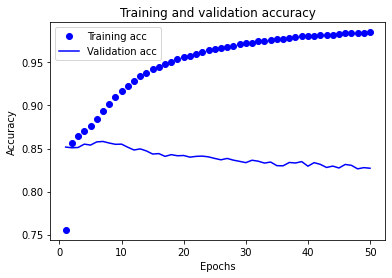

[('블리', 0.7676373720169067),
 ('로맨스', 0.765102207660675),
 ('폭발', 0.7389097213745117),
 ('해서인지', 0.7310803532600403),
 ('유오', 0.7213609218597412),
 ('..;', 0.7169008255004883),
 ('포인트', 0.7114329934120178),
 ('..?', 0.71129310131073),
 ('늬', 0.710490882396698),
 ('동시', 0.7022039890289307)]

In [105]:
# loss auc 시각화
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_rnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("재미")